In [1]:
import numpy as np
import math
from sortedcontainers import SortedDict
import random
from scipy.stats import truncnorm
import csv
import sys
import copy
import imp
from scipy.stats import norm

import matplotlib.pyplot as plt
from celluloid import Camera #need to install it (pip install celluloid)

In [2]:
#inputs
num_gens = 150
change_pos = 1
change_strat = 0
sd_adjust = 1

strat_interval = .05
pos_interval = 50

males = 10
dist_val = 1000
RB_time_val = 6 #hrs

male_pos=[0,50,100,150, 200, 250, 300, 350, 400, 450]
# male_pos=[0,100,200, 300, 400, 500, 600, 700, 800, 900]
male_strat=[.15,.15,.15,.15,.15,.15,.15,.15,.15,.15]


if len(male_pos)!=males | len(male_strat)!=males:
    print("ERROR -- # of males doesn't match pos/strat input")

#THE WRITER DOCUMENT
t_max = 12 * 30 # time when simulation ends


 # FEMALES
F_per_M = 9 #The number of sexualy mature females per sexually mature male
females = males * F_per_M # number of female birds
#BELOW: FV_std * truncnorm.rvs(FV_norm_range[0], FV_norm_range[1]) + FV_mean
FV_std = t_max / 4 
FV_mean = t_max / 2
FV_range = [0, t_max]
FV_norm_range =  [(FV_range[0] - FV_mean) / FV_std, (FV_range[1] - FV_mean) / FV_std]
female_visit_param = [FV_std, FV_mean, FV_norm_range[0], FV_norm_range[1]]  

# POSITIONS AND TRAVEL TIME
dist = dist_val # distance between males
bird_speed = 12 * 3600 # m/hr (12 m/s)
# now choose lambda_dist, controlling the probability of traveling to a neighbor
# the probability of choosing a neighbor at distance x is proportional to exp(-\lambda x)
# choose lambda such that 99% of the mass is before 800 meters
improb_dist = 800
improb_sds = 2
#if using exp decay
#lambda_dist = - math.log(1.0 - improb) / improb_distance


# ACTION DISTRIBUTIONS
# Time of forage
FG_tau_mean, FG_tau_std = .4, .167 #mean and sd of truncated normal distribution rv to find a male's time until next FG
FG_tau_range = [0, 1] #maximum and minimum FG taus
FG_tau_norm_range = [(FG_tau_range[0] - FG_tau_mean) / FG_tau_std, (FG_tau_range[1] - FG_tau_mean) / FG_tau_std] #normalized
# Duration of forage
FG_k=1.5 #the shape of the gamma distribution rv used to generate FG taus
FG_theta=5 #the scale of the gamma distribution rv used to generate FG taus
FG_divisor=60 #helps scale gamma distritbution
# Duration of repair bower / stay at bower
RBSB_tau_mean, RBSB_tau_std = .1583, .09755 #mean and sd of truncated normal distribution rv to find duration of repair bower / stay at bower
RBSB_tau_range = [0,.5] #maximum and minimum taus
RBSB_tau_norm_range = [(RBSB_tau_range[0] - RBSB_tau_mean) / RBSB_tau_std, (RBSB_tau_range[1] - RBSB_tau_mean) / RBSB_tau_std] #normalized

time_spent_marauding=.1

damage_to_bower = RB_time_val

#Male strategies
##C_or_D='D'

##max_maraud=max_m_val
#prop_maraud=round(m_prop_val,3) #only useful in discrete case #using round as a precaution because we got weird things last time
##mar_ids = 'np.random.permutation(males)[0:n_mar]'




In [3]:
def compute_distances_travel_times(males, positions, bird_speed, dist):
    male_dist = np.zeros((males, males))
    travel_times = np.zeros((males, males))
    for i in range(males):
        for j in range(i + 1, males):
            diff = abs(positions[i]-positions[j])
            ib_dist = min(diff, dist-diff)#math.sqrt((positions[0][j] - positions[0][i]) ** 2 + (positions[1][j] - positions[1][i]) ** 2)
            travel = ib_dist / bird_speed
            male_dist[j][i] = ib_dist
            male_dist[i][j] = ib_dist
            travel_times[j][i] = travel
            travel_times[i][j] = travel
    return (male_dist, travel_times)

def compute_visit_preferences(males, distances, improb_dist, improb_sds):
    # compute exponential of each coefficient
    visit_preferences = abs(norm.pdf(distances, 0, improb_dist/improb_sds))
    # remove the identity matrix (exp(0) = 1)
    np.fill_diagonal(visit_preferences,0.0)
    # make rows sum to one
    visit_preferences = (visit_preferences.transpose() / np.sum(visit_preferences, 1)).transpose()
    return visit_preferences

# functions to generate tickets and manage timeline
def generate_ticket(start_time, end_time, length_activity, owner, action, target):
    global timeline
    ticket = {"start_time": start_time,
              "end_time": end_time,
              "length_activity": length_activity,
              "owner": owner,
              "action": action,
              "target": target
             }
    # now add to timeline
    timeline[(ticket["end_time"], ticket["owner"])] = ticket
# ACTION FUNCTIONS
# Each action generates a ticket, and updates the state of the owner (and possibly the target)

def draw_foraging_time(start_time):
    time_between = FG_tau_std * truncnorm.rvs(FG_tau_norm_range[0], FG_tau_norm_range[1]) + FG_tau_mean
    return start_time + time_between

def action_forage(bird_id, current_time):
    global birds
    my_bird=birds[bird_id]
    # generate the time it takes to forage
    time_spent_foraging = np.random.gamma(FG_k, FG_theta)/FG_divisor
    time_action_ends = current_time + time_spent_foraging
    # generate the ticket
    generate_ticket(start_time = current_time,
                   end_time = time_action_ends,
                   length_activity = time_spent_foraging,
                   owner = bird_id,
                   action = "foraging",
                   target = -1)
    # update the bird:
    my_bird["current_state"] = "foraging"
    my_bird["action_starts"] = current_time
    my_bird["action_ends"] = time_action_ends
    my_bird["foraging_time_data"] += np.array([1, time_spent_foraging, time_spent_foraging * time_spent_foraging])
    # update the time to next foraging: start counting when foraging ended
    birds[bird_id]["next_foraging_time"] = draw_foraging_time(time_action_ends)

def action_stay_at_bower(bird_id, current_time):
    global birds
    my_bird=birds[bird_id]
    # generate the length of the stay
    time_spent_at_bower = RBSB_tau_std * truncnorm.rvs(RBSB_tau_norm_range[0], RBSB_tau_norm_range[1]) + RBSB_tau_mean
    time_action_ends = current_time + time_spent_at_bower
    # generate the ticket
    generate_ticket(start_time = current_time,
                   end_time = time_action_ends,
                   length_activity = time_spent_at_bower,
                   owner = bird_id,
                   action = "staying at bower",
                   target = -1)
    # update the bird:
    my_bird["current_state"] = "staying at bower"
    my_bird["action_starts"] = current_time
    my_bird["action_ends"] = time_action_ends
    my_bird["staying_time_data"] += np.array([1, time_spent_at_bower, time_spent_at_bower * time_spent_at_bower])

def action_travel_to_maraud(bird_id, current_time):
    global birds
    my_bird=birds[bird_id]
    # choose who to maraud
    tmp = np.random.rand()
    target = np.argwhere(birds[bird_id]["travel_preferences"] > tmp)[0][0] 
    time_to_travel = birds[bird_id]["travel_times"][target]
    time_action_ends = current_time + time_to_travel
    # generate the ticket
    generate_ticket(start_time = current_time,
                   end_time = time_action_ends,
                   length_activity = time_to_travel,
                   owner = bird_id,
                   action = "travel to maraud",
                   target = target)
    # update the bird:
    my_bird["current_state"] = "travel to maraud"
    my_bird["action_starts"] = current_time
    my_bird["action_ends"] = time_action_ends
    my_bird["traveling_time_data"] += np.array([1, time_to_travel * 2, time_to_travel * time_to_travel * 4])
    #NOTE: use * 2 to account for return time, as well
    
def action_repair_bower(bird_id, current_time):
    global birds
    my_bird=birds[bird_id]
    # generate the length of the repair bout
    time_spent_repairing_bower = RBSB_tau_std * truncnorm.rvs(RBSB_tau_norm_range[0], RBSB_tau_norm_range[1]) + RBSB_tau_mean
    time_action_ends = current_time + time_spent_repairing_bower
    # generate the ticket
    generate_ticket(start_time = current_time,
                   end_time = time_action_ends,
                   length_activity = time_spent_repairing_bower,
                   owner = bird_id,
                   action = "repairing bower",
                   target = -1)
    # update the bird:
    my_bird["current_state"] = "repairing bower"
    my_bird["action_starts"] = current_time
    my_bird["action_ends"] = time_action_ends
    my_bird["repairing_time_data"] += np.array([1, time_spent_repairing_bower, time_spent_repairing_bower * time_spent_repairing_bower])
    # note: already accounts for the improvements
    my_bird["bower_state"] = birds[bird_id]["bower_state"] + time_spent_repairing_bower
    # cannot make it better than 0
    if my_bird["bower_state"] > 0.0:
        my_bird["bower_state"] = 0.0

def action_maraud(marauder_id, marauder_target, current_time):
    global birds
    my_bird=birds[marauder_id]
    # note: HARD CODED PARAMS!
    time_spent_marauding = 0.1 
    # note: HARD CODED PARAMS!
    #damage_to_bower = 6.0 
    time_action_ends = current_time + time_spent_marauding
    # generate the ticket
    generate_ticket(start_time = current_time,
                   end_time = time_action_ends,
                   length_activity = time_spent_marauding,
                   owner = marauder_id,
                   action = "marauding",
                   target = marauder_target)
    # update marauder
    my_bird["current_state"] = "marauding"
    my_bird["action_starts"] = current_time
    my_bird["action_ends"] = time_action_ends
    my_bird["marauding_time_data"] += np.array([1, time_spent_marauding, time_spent_marauding * time_spent_marauding]) # add one more travel event
    # update target
    birds[marauder_target]["bower_state"] = birds[marauder_target]["bower_state"] - damage_to_bower
    

def action_travel_from_maraud(marauder_id, marauder_target, current_time):
    global birds
    my_bird=birds[marauder_id]
    time_from_travel = birds[marauder_id]["travel_times"][marauder_target]
    time_action_ends = current_time + time_from_travel
    # generate the ticket
    generate_ticket(start_time = current_time,
                   end_time = time_action_ends,
                   length_activity = time_from_travel,
                   owner = marauder_id,
                   action = "travel from maraud",
                   target = marauder_target)
    # update the bird:
    my_bird["current_state"] = "travel from maraud"
    my_bird["action_starts"] = current_time
    my_bird["action_ends"] = time_action_ends


    
def action_mating_attempt(female_id, current_time):
    global birds
    global female_birds
    female_index = int(female_id[1:]) #convert from ID to index; i.e. "F0" -> 0
    female = female_birds[female_index] # extract female
    last_location = female["already_visited"][-1] #index of most recently visited male
    p = birds[last_location]["travel_preferences"].copy()
    # this line "undoes" the cumulative sum
    p = np.diff(np.concatenate((np.array([0]), p)))
    extra_wait = 0.0 
    if len(female["already_visited"]) == female["max_per_day"]:
        female["already_visited"] = []
        extra_wait = female["wait_period"]  #HARD CODE
    tmp = np.random.rand()
    p = np.cumsum(p)
    scale_rand = p[-1]
    tmp = np.random.rand() * scale_rand
    target = np.argwhere(p > tmp)[0][0]
    time_to_travel = birds[last_location]["travel_times"][target]
    time_action_ends = current_time + time_to_travel
    generate_ticket(start_time = time_action_ends + extra_wait, 
                    end_time = time_action_ends + extra_wait,
                    length_activity = time_to_travel + extra_wait,
                    owner = female_id,
                    action = "mating attempt",
                    target = target)

# this function should be called every time the bird 
# 1) is back to the bower (from foraging, marauding), 
# 2) has finished repairing the bower, 
# 3) or has finished a stint at staying at bower
def choose_action(bird, current_time):
    global t_max
    # stop generating actions at t_max
    if current_time < t_max:
        # if it's time to eat
        if current_time > bird["next_foraging_time"]:
            action_forage(bird["id"], current_time)
        # if the bower needs repair
        elif bird["bower_state"] < 0.0:
            # go repair
            action_repair_bower(bird["id"], current_time)
        # check if it wants to maraud
        elif np.random.rand() < bird["probability_maraud"]:
            # go maraud
            action_travel_to_maraud(bird["id"], current_time)
        else:
            # stay at bower
            action_stay_at_bower(bird["id"], current_time)

def initialize_male(bird_id, bird_strategy, bird_pos, bird_preferences, bird_travel_times):
    # initialize dictionary
    bird = {"id": bird_id,
            "current_state": "none",
            "action_starts": 0.0,
            "action_ends": -1.0,
            "probability_maraud": bird_strategy,
            "bower_state": 0.0,
            "successful_mating": 0,
            "next_foraging_time": draw_foraging_time(0.0),
            "travel_preferences": np.cumsum(bird_preferences), # note: store cumulative probability for faster choice
            "travel_times": bird_travel_times, 
            "position": bird_pos,
            "foraging_time_data": np.array([0.0, 0.0, 0.0]), #number of events, cumulative time spent, sum(duration^2)
            "staying_time_data": np.array([0.0, 0.0, 0.0]),
            "repairing_time_data": np.array([0.0, 0.0, 0.0]),
            "marauding_time_data": np.array([0.0, 0.0, 0.0]),
            "traveling_time_data": np.array([0.0, 0.0, 0.0])
            }
    return(bird)
#DECIDE HOW MUCH TO KEEP. MAYBE REINITIALIZE EACH TIME BUT JUST KEEP STRATEGY AND POSITION!!!

def initialize_female(female_id, males):
    #initialize dictionary
    female_bird = {"id": female_id,
             "already_visited": [np.random.randint(males)], # choose a random male to be the "last visited"
             "max_per_day": min(males - 1, 6),
             "wait_period": 12,
            #HARD CODED PARAMS
            }
    return(female_bird)

# this is the most important function!
def read_ticket(tic):
    global birds
    global t_max
    if tic["action"] in ("foraging", "staying at bower", "repairing bower", "travel from maraud"):
        # I am back at the bower, choose new action
        choose_action(birds[tic["owner"]], tic["end_time"])
    elif tic["action"] == "travel to maraud":
        # check whether the target is at home
        go_maraud = True
        if birds[tic["target"]]["current_state"] in ("staying at bower", "repairing bower"):
            go_maraud = False
        if birds[tic["target"]]["bower_state"] < 0.0:
            go_maraud = False
        if go_maraud: # maraud
            action_maraud(tic["owner"], tic["target"], tic["end_time"])
        else: # go back
            action_travel_from_maraud(tic["owner"], tic["target"], tic["end_time"])
    elif tic["action"] == "marauding":
        # travel back
        action_travel_from_maraud(tic["owner"], tic["target"], tic["end_time"])
    elif tic["action"] == "mating attempt":
        if birds[tic["target"]]["current_state"] == "staying at bower": #if male is at bower and it is intact
            birds[tic["target"]]["successful_mating"] += 1 #successfully mate and stop generating tickets
        else:  
            female_birds[int(tic["owner"][1:])]["already_visited"].append(tic["target"]) #update the female's already_visited list
            if tic['end_time'] < t_max:
                action_mating_attempt(tic["owner"], tic["end_time"]) #generate a new ticket
    else:
        1 / 0 # something went horribly wrong
        
# def clean_bird_for_output(bi):
#     j = copy.deepcopy(bi)
#     # remove unneeded stats
#     del j['current_state']
#     del j['action_starts']
#     del j['action_ends']
#     del j['bower_state']
#     del j['travel_preferences']
#     del j['travel_times']
# #     # extract positions
# #     j["x_pos"] = bi["position"][0]
# #     j["y_pos"] = bi["position"][1]
# #     del j['position']
#     # extract time statistics
#     activity_names=["foraging", "staying", "repairing", "marauding", "traveling"]
#     for i in activity_names:  
# #         j[i+"_events"] = bi[i+"_time_data"][0]
# #         j[i+"_hrs"] = bi[i+"_time_data"][1]
# #         j[i+"_sqhrs"] = bi[i+"_time_data"][2]
#         del j[i+"_time_data"]
#     return j 

# simulation_output = runsimulation(t_max, males, F_per_M, females,female_visit_param, dist, bird_speed, improb_sds,improb_dist,FG_tau_mean, FG_tau_std,FG_tau_range, FG_tau_norm_range,FG_k, FG_theta, FG_divisor,RBSB_tau_mean, RBSB_tau_std, RBSB_tau_norm_range, mar_ids, damage_to_bower, max_maraud)

# f = open(myin.out_title, "w+")
# dw = csv.DictWriter(f, clean_bird_for_output(simulation_output[0]).keys())
# dw.writeheader()
# for i in simulation_output:
#     dw.writerow(clean_bird_for_output(i))
# f.close()

In [4]:
def runsimulation(t_max, males, F_per_M, females,female_visit_param, dist, bird_speed, improb_sds,improb_dist,FG_tau_mean, FG_tau_std,FG_tau_range, FG_tau_norm_range,FG_k, FG_theta, FG_divisor,RBSB_tau_mean, RBSB_tau_std, RBSB_tau_norm_range, damage_to_bower, male_pos, male_strat):
    global birds
    global timeline
    global female_birds
    timeline = SortedDict()
    # BIRDS
    birds = []
    # initialize positions, travel times and preferences
    distances, travel_times = compute_distances_travel_times(males, male_pos, bird_speed, dist)
    visit_preferences = compute_visit_preferences(males, distances, improb_dist, improb_sds)
    for i in range(males):
        birds.append(initialize_male(i, 
                                     male_strat[i], 
                                     male_pos[i], 
                                     visit_preferences[i],
                                     travel_times[i]))
        # choose its first action
        choose_action(birds[-1], 0.0)
    #initialize females
    female_birds=[]
    for i in range(females): #females
        female_id = "F" + str(i)
        female_birds.append(initialize_female(female_id, males)) #female IDs start where males end (if there are 10 males, the first female would be 11)
        #choose time for initial mating attempt
        first_time =  female_visit_param[0] * truncnorm.rvs(female_visit_param[2], female_visit_param[3]) + female_visit_param[1] 
        action_mating_attempt(female_id, first_time)

    # this is the main loop
    while len(timeline) > 0:
        current_ticket = timeline.popitem(0)
        read_ticket(current_ticket[1])
    return birds

In [5]:
def adjust_pos(pos, dist, pos_interval, sd_below):
    rnd = np.random.uniform(-pos_interval,pos_interval)
    rnd_sd = sd_below*rnd
    #print(rnd, rnd_sd) #test - seems to work
    new_pos = rnd_sd + pos
    if new_pos < 0:
        new_pos = new_pos + dist
    return round(new_pos, 0)


def adjust_strat(strat, strat_interval, sd_below):
    rnd = np.random.uniform(-strat_interval, strat_interval)
    rnd_sd = sd_below*rnd
    new_strat = rnd_sd + strat
    if new_strat < 0:
        new_strat=0
    if new_strat > 1:
        new_strat = 1
    return round(new_strat, 2)


MovieWriter imagemagick unavailable.


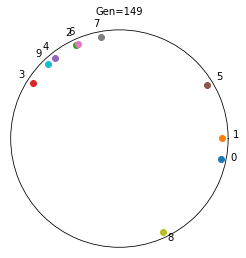

In [6]:
def evolve(t_max, males, F_per_M, females,female_visit_param, dist, bird_speed, improb_sds,improb_dist,FG_tau_mean, FG_tau_std,FG_tau_range, FG_tau_norm_range,FG_k, FG_theta, FG_divisor,RBSB_tau_mean, RBSB_tau_std, RBSB_tau_norm_range, damage_to_bower, male_pos, male_strat, num_gens, change_pos, change_strat, pos_interval, strat_interval, sd_adjust):
    global birds
    global timeline
    global female_birds
    fig = plt.figure()
    camera = Camera(fig)
    plt.axes(projection='polar')

    for i in range(num_gens):
#        print("LOOP", i)
        birds = runsimulation(t_max, males, F_per_M, females,female_visit_param, dist, bird_speed, improb_sds,improb_dist,FG_tau_mean, FG_tau_std,FG_tau_range, FG_tau_norm_range,FG_k, FG_theta, FG_divisor,RBSB_tau_mean, RBSB_tau_std, RBSB_tau_norm_range, damage_to_bower, male_pos, male_strat)
#         birds_in_time = []
#         for num in range(males):
#             birds_in_time[clean_bird_for_output(birds[num])] #is this how code works???
#         for bird in birds: 
#             print("bird", bird["id"])
#             print("matings", bird["successful_mating"])
#             print("strat", bird["probability_maraud"])
#             print("pos", bird["position"])
            
#         plt.axes(projection='polar')
        # set the locations of the radial gridlines
        rads = np.array([male_p/dist for male_p in male_pos]) * 2 * np.pi
        for id in range(males):
            radian = rads[id]
            plt.polar(radian, 1,'o', color=  plt.cm.tab10(id)) 
            if np.cos(radian)>0:
                al="left"
            else:
                al="right"
            stratstr = ""
            if change_strat==1:
                stratstr=": " + str(birds[id]["probability_maraud"])
            lab=str(id) + stratstr
            plt.text(radian, 1.1, lab, horizontalalignment=al)
        plt.text(np.pi/2, 1.2, "".join(["Gen=", str(i)]), horizontalalignment="center") 
#         lines, labels = plt.rgrids( () )
#         lines, labels = plt.thetagrids( () )
        #plt.show()

        #plt.title("".join(["Gen=", str(i)]), horizontalalignment="center") #only does last generation
        camera.snap()
        
        underperformer_ids = [bird["id"] for bird in birds if bird["successful_mating"] < 9]
        #print("underperformers:" underperformer_ids)
        sd=np.std([bird["successful_mating"] for bird in birds])
        sd_below=1
        for up_id in underperformer_ids:
            if sd_adjust==1:
                sd_below=(9-birds[up_id]["successful_mating"])/sd
            if change_pos == 1:
                male_pos[up_id]=adjust_pos(birds[up_id]["position"], dist, pos_interval, sd_below)
            if change_strat == 1:
                male_strat[up_id]=adjust_strat(birds[up_id]["probability_maraud"], strat_interval, sd_below)
    lines, labels = plt.rgrids( () )
    lines, labels = plt.thetagrids( () )
    animation = camera.animate(interval=500) #a good rate, seems independent of # of gens
    plt.rcParams["animation.convert_path"] = "C:\ProgramFiles\ImageMagick\magick.exe"
    animation.save('test_evolve.gif', writer="imagemagick", extra_args="convert")
                
                
evolve(t_max, males, F_per_M, females,female_visit_param, dist, bird_speed, improb_sds,improb_dist,FG_tau_mean, FG_tau_std,FG_tau_range, FG_tau_norm_range,FG_k, FG_theta, FG_divisor,RBSB_tau_mean, RBSB_tau_std, RBSB_tau_norm_range, damage_to_bower, male_pos, male_strat, num_gens, change_pos, change_strat, pos_interval, strat_interval, sd_adjust)